<a href="https://colab.research.google.com/github/aliabdari/compressed-QA/blob/main/QA_compressed_domain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow import keras

In [40]:
import numpy as np
x_temp = np.load('/content/drive/MyDrive/information_live/x_vgg16.npy',allow_pickle= True)

In [41]:
x_temp.shape[0]

160

In [42]:
x_temp2 = np.empty(150,dtype=object)

In [43]:
idx = 0
for i in range(x_temp.shape[0]):
  if i % 16 == 0:
    continue
  x_temp2[idx] = x_temp[i]
  idx+=1

In [44]:
x_temp2.shape

(150,)

## Load DOM

In [45]:
y_temp = np.loadtxt('/content/drive/MyDrive/live_dataset_Reconstructed_Residuals/live_video_quality_data.txt')

In [46]:
y_temp.shape

(150, 2)

In [47]:
y = y_temp[:,0]

In [48]:
y = np.asarray(y).astype('float32')

In [49]:
max_y = np.max(y)

In [50]:
y=y/max_y

## POT

In [51]:
np.mean(x_temp2[10], axis=1).shape

(4096,)

In [52]:
x = np.empty((150,4096),dtype=object)
for i in range(x_temp2.shape[0]):
  x[i,:] = np.mean(x_temp2[i], axis=1)
  pass

In [53]:
x.shape

(150, 4096)

In [54]:
x = np.asarray(x).astype('float32')

In [55]:
np.max(x)

4.789821

In [56]:
x = x/np.max(x)

# Data preparation

In [57]:
x_test = x[0:30,:].copy()
y_test = y[0:30].copy()

In [58]:
x_test.shape

(30, 4096)

In [59]:
x_train = x[30:,:].copy()
y_train = y[30:].copy()

In [60]:
x_train.shape

(120, 4096)

In [61]:
def do_shuffle(X,Y,number_of_data):
  shuffle_index = np.arange(number_of_data)
  np.random.shuffle(shuffle_index)
  return X[shuffle_index],Y[shuffle_index]

In [62]:
x_train,y_train = do_shuffle(x_train,y_train,120)

In [63]:
x_train.dtype

dtype('float32')

## Model

In [64]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.08, shuffle= True)

In [65]:
model = Sequential()
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.35))
model.add(Dense(16, activation="linear"))
model.add(Dropout(0.25))
model.add(Dense(8,activation="linear"))
model.add(Dense(4,activation="linear"))
model.add(Dense(1, activation="linear"))

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

opt = Adam(learning_rate=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_squared_error", optimizer=opt)

history = model.fit(x=x_train, y=y_train, 
	validation_data=(x_valid, y_valid),
	epochs=60, 
	batch_size=64,
	callbacks = callbacks)

Epoch 1/60
2/2 [==============================] - 1s 155ms/step - loss: 2.2719 - val_loss: 0.0564
Epoch 2/60
2/2 [==============================] - 0s 65ms/step - loss: 0.4695 - val_loss: 0.0242
Epoch 3/60
2/2 [==============================] - 0s 24ms/step - loss: 0.2128 - val_loss: 0.1484
Epoch 4/60
2/2 [==============================] - 0s 25ms/step - loss: 0.1773 - val_loss: 0.2135
Epoch 5/60
2/2 [==============================] - 0s 24ms/step - loss: 0.2248 - val_loss: 0.2292
Epoch 6/60
2/2 [==============================] - 0s 23ms/step - loss: 0.1784 - val_loss: 0.1949
Epoch 7/60
2/2 [==============================] - 0s 26ms/step - loss: 0.2133 - val_loss: 0.1429
Epoch 8/60
2/2 [==============================] - 0s 24ms/step - loss: 0.1698 - val_loss: 0.0952
Epoch 9/60
2/2 [==============================] - 0s 26ms/step - loss: 0.1516 - val_loss: 0.0619
Epoch 10/60
2/2 [==============================] - 0s 31ms/step - loss: 0.1208 - val_loss: 0.0474
Epoch 11/60
2/2 [===========

## Plot

In [66]:
import matplotlib.pyplot as plt

def plot_diagrams_trian_process(history):
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.legend(['loss','val_loss'])

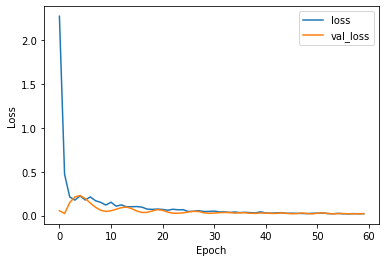

In [67]:
plot_diagrams_trian_process(history.history)

##Predict

In [68]:
y_test_predict = model.predict(x_test)
y_test_predict *= max_y

In [69]:
y_test_orig = y_test * max_y

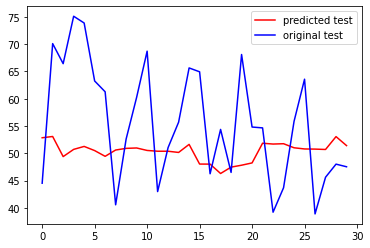

In [70]:
plt.plot(y_test_predict, label = 'predicted test' ,color = 'red')
plt.plot(y_test_orig, label = 'original test' ,color = 'blue')
plt.legend()

In [71]:
from scipy import stats
rho, pval = stats.spearmanr(y_test_predict, y_test_orig)

In [72]:
y_train_predict = model.predict(x_train)
y_train_predict *= max_y
y_train_orig = y_train * max_y

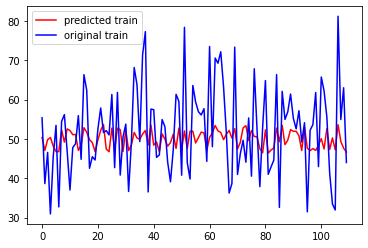

In [73]:
plt.plot(y_train_predict, label = 'predicted train' ,color = 'red')
plt.plot(y_train_orig, label = 'original train' ,color = 'blue')
plt.legend()